
https://www.kaggle.com/c/costa-rican-household-poverty-prediction/submissions?sortBy=date&group=all&page=1

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Read the train data
dataset=pd.read_csv('train.csv')
dataset.shape


(9557, 143)

# Check the datatypes of the dataset




In [5]:
dtype = dataset.dtypes.reset_index()
# reset_index() is a method to reset index of a Data Frame. reset_index() method sets a list of integer ranging from 0 to length of data as index.
dtype.columns = ["Count", "Column Type"]
''' A data type object describes how the bytes in the fixed-size block of memory corresponding to an array item should be interpreted.
It describes the following aspects of the data:
Type of the data (integer, float, Python object, etc.)
Size of the data (how many bytes is in e.g. the integer)
'''
dtype.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,130
1,float64,8
2,object,5


## Check the label distribution 

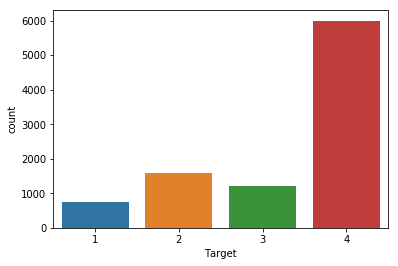

In [6]:
# Lets plot a bar plot to show the distribution of training labels
sns.countplot(x="Target",  data=dataset)


## Addressing Wrong Labels

In [7]:
#  The data contains individuals with the same household and have a different poverty level
#  we are going to fix that


# Households where targets are equla
#  groupby() apply given function to group, return result as series
all_dataset = dataset.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

#House Holds where targets are not eqaul
not_equal_dataset=all_dataset[all_dataset==False]

print('{} of the householders have members with different wrong targets'.format(len(not_equal_dataset)))


85 of the householders have members with different wrong targets


### Fixing Worng labels

In [10]:
# Iterate through each household
# here the house hold represnts the idgogar
for household in not_equal_dataset.index:
    
    # Find the correct label (for the head of household)
    # & takes the intersection od two sets
    true_target = int(dataset[(dataset['idhogar'] == household) & (dataset['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    dataset.loc[dataset['idhogar'] == household, 'Target'] = true_target

In [359]:
# check now if there is wrong labels
all_dataset = dataset.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

#House Holds where targets are not eqaul
not_equal_dataset=all_dataset[all_dataset==False]

print('{} of the householders have members with different wrong targets'.format(len(not_equal_dataset)))

0 of the householders have members with different wrong targets


# Find the columns that have missing valus


In [360]:
list(dataset.columns[dataset.isnull().sum() != 0])

['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned']

In [361]:
def print_missing_values(dataset):
    missing_datafram=dataset.isna().sum(axis=0).reset_index()
    missing_datafram.columns = ['column name', 'missing values count']
    missing_datafram = missing_datafram[missing_datafram['missing values count']>0]
    print(missing_datafram)
    
print_missing_values(dataset)


    column name  missing values count
1          v2a1                  6860
8         v18q1                  7342
21      rez_esc                  7928
103    meaneduc                     5
140   SQBmeaned                     5


# Handling missing values

####  Fisrt: Handling the missing valuse in meaneduc,average years of education for adults (18+)
####  we are going to use the the mean


In [362]:
from sklearn.preprocessing import Imputer
imputer=Imputer(missing_values='NaN',strategy='mean',axis=0)

In [363]:
dataset.iloc[:,103:104]=imputer.fit_transform(dataset.iloc[:,103:104])
print_missing_values(dataset)

    column name  missing values count
1          v2a1                  6860
8         v18q1                  7342
21      rez_esc                  7928
140   SQBmeaned                     5


####  second: Handling the missing valuse in SQBmeaned, square of the mean years of education of adults (>=18) in the household

####  we are going to use the the mean


In [364]:
dataset.iloc[:,140:141]=imputer.fit_transform(dataset.iloc[:,140:141])
print_missing_values(dataset)

   column name  missing values count
1         v2a1                  6860
8        v18q1                  7342
21     rez_esc                  7928


####  Third: Handling the missing valuse in v2al'Monthly rent payment'

#### Here the v2val means the mounthly rent payment, so they don't have a house, so we can replace the null value with 
#### zero for those who have a house( means 'tipovivi1'=1)


In [365]:
dataset[(dataset['v2a1'].isnull()==True) & (dataset['tipovivi1']==1)].shape


(5911, 143)

In [366]:
# here we can see that 5911 of missing values for those who don't have a house
# so we can replace thier v2al with zero since they don't pay fees for renting a house
dataset.loc[(pd.isnull(dataset['v2a1']) & dataset['tipovivi1'] == 1), 'v2a1'] = 0
dataset.isnull().sum()['v2a1']


949

In [367]:
# Check wether there is a relation between between the remaning missing values with region

regions = ['lugar1','lugar2','lugar3','lugar4','lugar5','lugar6']

for reg in regions:
    numberofMissing = dataset[(dataset['v2a1'].isnull()==True) & (dataset[reg]==1)].shape[0]
    numberOfRegoin = dataset[dataset[reg]==1].shape[0]
    ratio = numberofMissing/numberOfRegoin
    print("There are {} missing values in region{}, with ratio{}. \n"\
          .format(numberofMissing, numberOfRegoin,round(ratio,4)))

There are 411 missing values in region5616, with ratio0.0732. 

There are 78 missing values in region886, with ratio0.088. 

There are 117 missing values in region596, with ratio0.1963. 

There are 110 missing values in region791, with ratio0.1391. 

There are 147 missing values in region897, with ratio0.1639. 

There are 86 missing values in region771, with ratio0.1115. 



In [368]:
# We can see that there is no relation between the number of missing value and the region
# After refering to Kaggle disscussions, it seems that 'v2a1' will be a null value when households do not rent or households are not paying loans
#we will replace the rest of the null values with 0 as well.
dataset['v2a1'].fillna(0, inplace = True)


In [369]:
dataset.isnull().sum()['v2a1']


0

####  Fourth: Handling the missing valuse in v18q1'number of tablets household owns'

#### Lets chcek if there is a relation v18q1'number of tablets household owns' and vl8q'owns a tablet'




In [370]:
dataset[(dataset['v18q1'].isnull()==True) & (dataset['v18q']==0)].shape[0]==dataset.isnull().sum()['v18q1']


True

In [371]:
# we can see that 'V18q1' has a missing value for those who don't own a tablet so we can repalce the missing value by zero
dataset['v18q1'].fillna(0, inplace = True)


In [372]:
print_missing_values(dataset)

   column name  missing values count
21     rez_esc                  7928


####  Fifth: Handling the missing valuse in rez_esc Years behind school'

#### Now i will try to drop the 'rez-esc' since i dont know how to handle it




In [373]:
dataset = dataset.drop('rez_esc', axis = 1)


In [374]:
# No missing values
print_missing_values(dataset)

Empty DataFrame
Columns: [column name, missing values count]
Index: []


## Check if there any columns have constant values


In [12]:
# nunique() ==> Return Series with number of distinct observations over requested axis.
# Constant features can lead to errors in some models and obviously provide no information in the training set that can be learned from.

dataset1 = dataset.nunique().reset_index()
dataset1.columns = ["column name", "unique count"]
dataset1=dataset1[dataset1["unique count"]==1]
dataset1


,column name,unique count
62,elimbasu5,1


In [376]:
# drop column elimbasu5 since it has a constant value
dataset= dataset.drop(['elimbasu5'],axis=1)


## To check which columns have an object type


In [377]:
dataset.columns.to_series().groupby(dataset.dtypes).groups

{dtype('int64'): Index(['hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'r4h1', 'r4h2',
        'r4h3', 'r4m1',
        ...
        'area1', 'area2', 'age', 'SQBescolari', 'SQBage', 'SQBhogar_total',
        'SQBedjefe', 'SQBhogar_nin', 'agesq', 'Target'],
       dtype='object', length=129),
 dtype('float64'): Index(['v2a1', 'v18q1', 'meaneduc', 'overcrowding', 'SQBovercrowding',
        'SQBdependency', 'SQBmeaned'],
       dtype='object'),
 dtype('O'): Index(['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa'], dtype='object')}

In [378]:
# ['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa'] has object type
dataset[['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']].head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


In [379]:
# we are going to replace yes and no with o and 1
dataset=dataset.replace('no','0')
dataset=dataset.replace('yes','1')

## Drop the idhogar

In [380]:
# i have tried to encode but it gave en error when i applyed the RandomForest
dataset.drop(['idhogar'], axis = 1, inplace = True)


## Splitting data into dependent and independent variable


In [381]:
x=dataset.iloc[:,1:-1]

In [382]:
x.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,190000.0,0,3,0,1,1,0,0.0,0,1,...,43,100,1849,1,100,0,1.000000,0.0,100.0,1849
1,135000.0,0,4,0,1,1,1,1.0,0,1,...,67,144,4489,1,144,0,1.000000,64.0,144.0,4489
2,0.0,0,8,0,1,1,0,0.0,0,0,...,92,121,8464,1,0,0,0.250000,64.0,121.0,8464
3,180000.0,0,5,0,1,1,1,1.0,0,2,...,17,81,289,16,121,4,1.777778,1.0,121.0,289
4,180000.0,0,5,0,1,1,1,1.0,0,2,...,37,121,1369,16,121,4,1.777778,1.0,121.0,1369


In [383]:
y=dataset.iloc[:,-1]

### An attempt to handle the Impalanced data using Use Tree-Based Algorithms

In [384]:
#  ## Use Tree-Based Algorithms to handle the impalanced data
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score



# # Train model
# clf_4 = RandomForestClassifier()
# clf_4.fit(x, y)
 
# # Predict on training set
# pred_y_4 = clf_4.predict(x)
 
# # Is our model still predicting just one class?
# print( np.unique( pred_y_4 ) )
# # [0 1]
 
# # How's our accuracy?
# print( accuracy_score(y, pred_y_4) )
# # 0.9744



 

## Preprocess test data


In [385]:
test_df=pd.read_csv('test.csv')
org_test=test_df



In [386]:
test_df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [387]:
print_missing_values(test_df)
# handling missing values
from sklearn.preprocessing import Imputer
imputer=Imputer(missing_values='NaN',strategy='mean',axis=0)
test_df.iloc[:,103:104]=imputer.fit_transform(test_df.iloc[:,103:104])
test_df.iloc[:,140:141]=imputer.fit_transform(test_df.iloc[:,140:141])
test_df['v2a1'].fillna(0, inplace = True)
test_df['v18q1'].fillna(0, inplace = True)
test_df = test_df.drop('rez_esc', axis = 1)

    column name  missing values count
1          v2a1                 17403
8         v18q1                 18126
21      rez_esc                 19653
103    meaneduc                    31
140   SQBmeaned                    31


In [388]:
# drop colums with constant values
test_df= test_df.drop(['elimbasu5'],axis=1)


In [389]:
#handle the non numeric values

test_df=test_df.replace('no','0')
test_df=test_df.replace('yes','1')

In [390]:
# drop the idhogar
test_df.drop(['idhogar'], axis = 1, inplace = True)


In [391]:
# drop the id
test_df.drop(['Id'], axis = 1, inplace = True)


In [392]:
#feature scalling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
x = sc.fit_transform(x) 
test_df= sc.fit_transform(test_df)  


In [393]:
x

(9557, 138)

In [394]:
# A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
# The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(x, y)
target_pred=classifier.predict(test_df)


In [395]:
sub=pd.DataFrame()
sub['Id']=org_test['Id']
sub['Target']=target_pred
sub.to_csv('submission.csv',index=False)

In [396]:
target_pred.size 

23856